# Inference on nuScenes mini dataset

In [1]:
import os
import copy
import glob
import torch
import random
import numpy as np
from tqdm import tqdm

from det3d import torchie
from det3d.datasets import build_dataloader, build_dataset
from det3d.models import build_detector
from det3d.torchie import Config
from det3d.torchie.apis import (
    batch_processor,
    build_optimizer,
    get_root_logger,
    init_dist,
    set_random_seed,
    train_detector,
)
from det3d.torchie.trainer import get_dist_info, load_checkpoint
from det3d.torchie.trainer.utils import all_gather, synchronize
from tools.demo_utils import visual

os.environ["CUDA_VISIBLE_DEVICES"] = '2'

no apex
No Tensorflow
Deformable Convolution not built!
No APEX!


In [3]:
work_dir = 'work_dirs/centerpoint_pillar_pretrain/demo-mini'
trt_work_dir = os.path.join(work_dir, 'tensorrt')
onnx_work_dir = os.path.join(work_dir, 'onnx')
os.makedirs(work_dir, exist_ok=True)
os.makedirs(trt_work_dir, exist_ok=True)
os.makedirs(onnx_work_dir, exist_ok=True)

cfg = Config.fromfile('configs/nusc/pp/nusc_centerpoint_pp_02voxel_two_pfn_10sweep_mini.py')

dataset = build_dataset(cfg.data.val)
data_loader = build_dataloader(
    dataset,
    batch_size=1,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=False,
    shuffle=False,
)

10


In [4]:
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version="v1.0-mini", verbose=True, dataroot='data/nuScenes-mini')

DETECTION_NAMES = [
    'car',
    'truck',
    'construction_vehicle',
    'bus',
    'trailer',
    'barrier',
    'motorcycle',
    'bicycle',
    'pedestrian',
    'traffic_cone',
    'ignore',
]

def convert_box(info):
    boxes =  info["gt_boxes"].astype(np.float32)
    names = info["gt_names"]
    tokens = info['gt_boxes_token']
    assert len(boxes) == len(names) == len(tokens)
    
    detection = {}
    detection['box3d_lidar'] = boxes
    # dummy value 
    detection['scores'] = np.ones(len(boxes))
    # object type
    label_preds = [DETECTION_NAMES.index(n) for n in names]
    detection['label_preds'] = np.array(label_preds, dtype=np.long)
    # tracking id
    sample_annotations = [nusc.get('sample_annotation', t) for t in tokens]
    tracking_ids = [s['instance_token'] for s in sample_annotations]
    detection['tracking_ids'] = np.array(tracking_ids, dtype=np.str)
    
    return detection

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.8 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## PyTorch Model

In [ ]:
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
checkpoint = load_checkpoint(model, 'work_dirs/centerpoint_pillar_pretrain/latest.pth', map_location="cpu")
model = model.cuda()
model.eval()

### prepare data

In [ ]:
points_dict = {}
gt_annos_dict = {}

for i, data in tqdm(enumerate(dataset), total=len(dataset)):
    token = data['metadata']['token']
    # points_list for visualization
    points = data['points'][:, :3]
    points_dict[token] = points.T
    # gt_annos for visualization
    info = dataset._nusc_infos[i]
    gt_annos = convert_box(info)
    gt_annos_dict[token] = gt_annos

100%|██████████| 81/81 [00:11<00:00,  7.31it/s]


### inference

In [ ]:
token_list = []
detections = {}

for i, data_batch in tqdm(enumerate(data_loader), total=len(data_loader.dataset)):
    with torch.no_grad():
        outputs = batch_processor(
            model, data_batch, train_mode=False, local_rank=0
        )
    for output in outputs:
        token = output["metadata"]["token"]
        token_list.append(token)
        for k, v in output.items():
            if k not in [
                "metadata",
            ]:
                output[k] = v.to(torch.device("cpu"))
        detections.update(
            {token: output,}
        )

100%|██████████| 81/81 [00:09<00:00,  8.95it/s]


### visualization

b22fa0b3c34f47b6a360b60f35d5d567


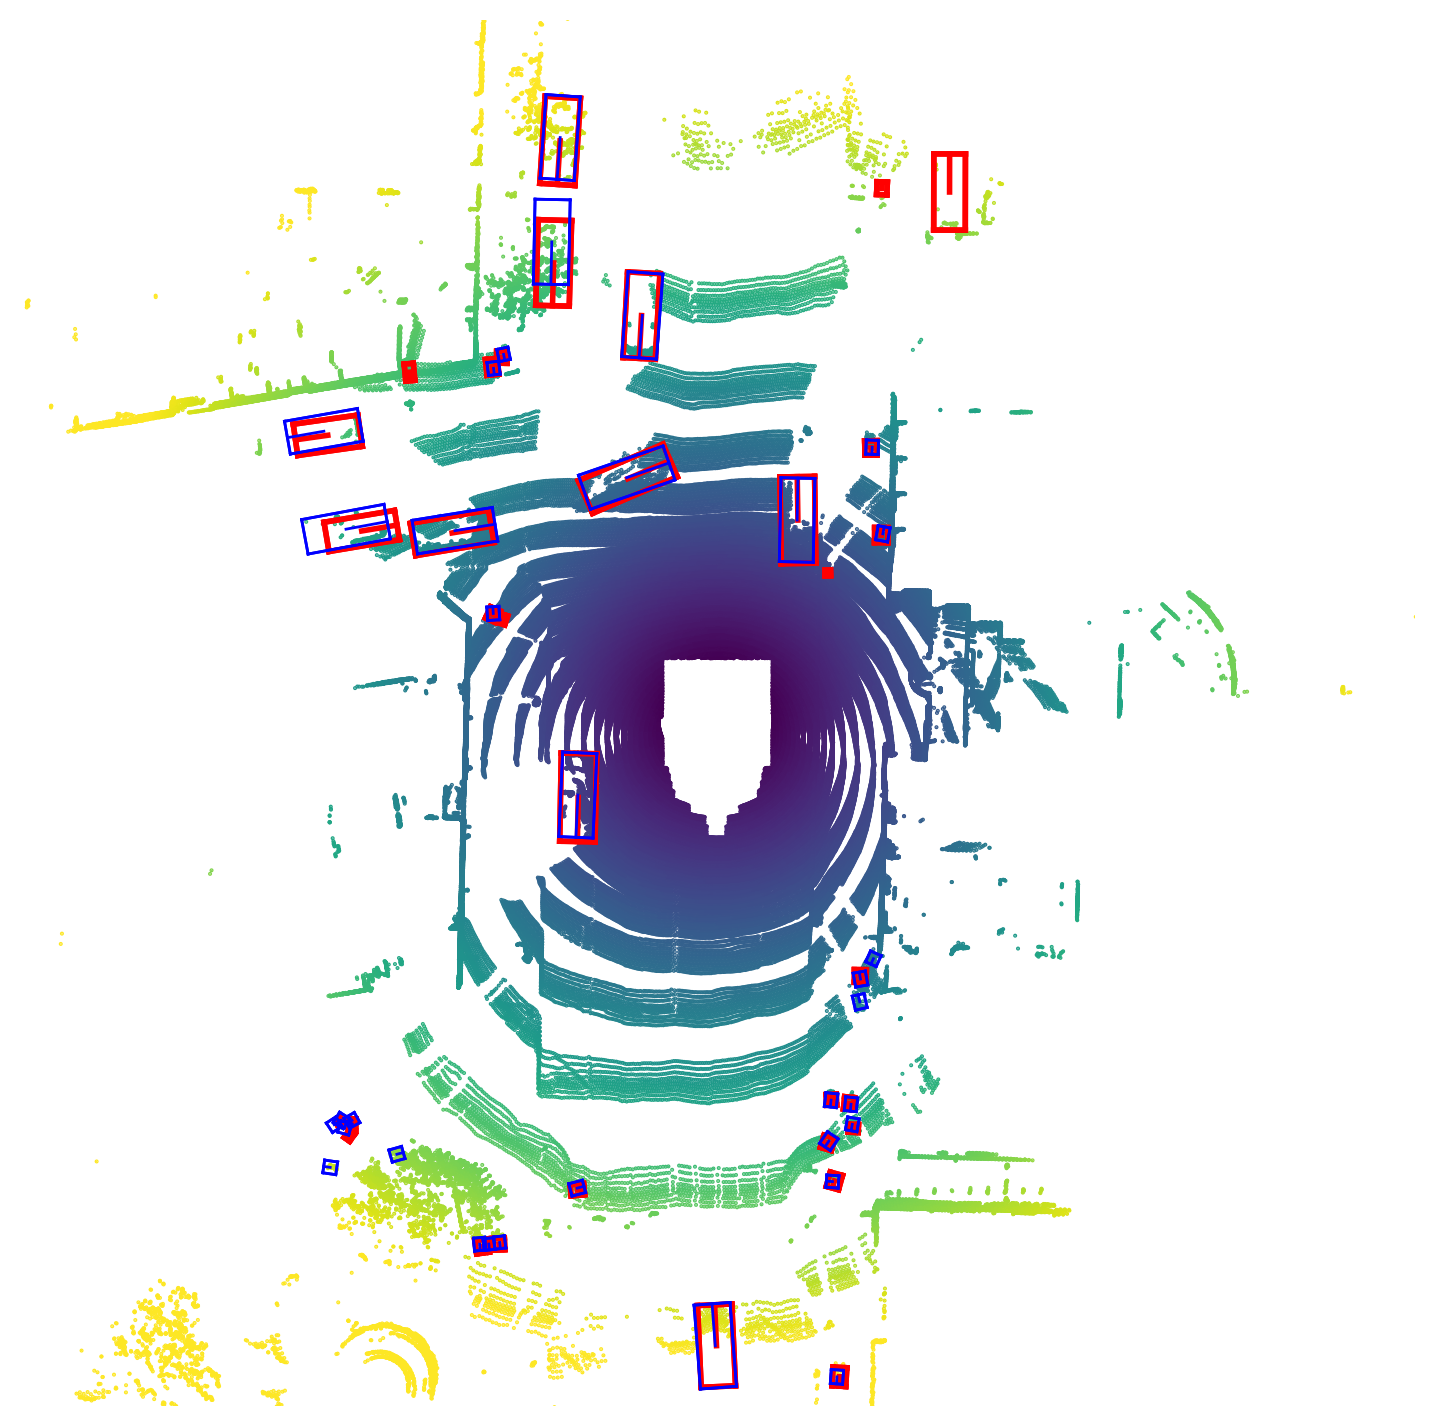

In [ ]:
vis_num = 1
draw_num = min(vis_num, len(token_list))
save_path = os.path.join(work_dir, "visual")
for token in random.sample(token_list, draw_num):
    print(token)
    visual(
        copy.deepcopy(points_dict[token]),
        copy.deepcopy(gt_annos_dict[token]),
        copy.deepcopy(detections[token]),
        token, save_path=None
    )

### evaluation

In [ ]:
all_predictions = all_gather(detections)

predictions = {}
for p in all_predictions:
    predictions.update(p)

result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=work_dir, testset=False)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.7 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Finish generate predictions for testset, save to work_dirs/centerpoint_pillar_pretrain/demo-mini/infos_val_10sweeps_withvelo_filter_True.json
Initializing nuScenes detection evaluation
Loaded results from work_dirs/centerpoint_pillar_pretrain/demo-mini/infos_val_10sweeps_withvelo_filter_True.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 286.64it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 17662
=> After distance based filtering: 14563
=> After LIDAR points based filtering: 14563
=> After bike rack filtering: 14496
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR points based filtering: 3393
=> After bike rack filtering: 3393
Rendering sample token b6c420c3a5bd4a219b1cb82ee5ea0aa7
Rendering sample token b22fa0b3c34f47b6a360b60f35d5d567
Rendering sample token d8251bbc2105497ab8ec80827d4429aa
Rendering sample token 372725a4b00e49c78d6d0b1c4a38b6e0
Rendering sample token ce94ef7a0522468e81c0e2b3a2f1e12d
Rendering sample token 0d0700a2284e477db876c3ee1d864668
Rendering sample token 61a7bd24f88a46c2963280d8b13ac675
Rendering sample token fa65a298c01f44e7a182bbf9e5fe3697
Rendering sample token 8573a885a7cb41d185c05029eeb9a54e
Rendering sample token 38a28a3aaf2647f2a8c0e90e31267bf8
Accumulating metric data.

## TensorRT Results

### prepare data

In [ ]:
trt_data_dir = "tensorrt/data/centerpoint/points"
os.makedirs(trt_data_dir, exist_ok=True)

points_dict = {}
gt_annos_dict = {}

for i, data in tqdm(enumerate(dataset), total=len(dataset)):
    token = data['metadata']['token']
    # save points for TensorRT
    data["points"].astype(np.float32).tofile(
        os.path.join(trt_data_dir, f"{token}.bin")
    )
    # points_list for visualization
    points = data['points'][:, :3]
    points_dict[token] = points.T
    # gt_annos for visualization
    info = dataset._nusc_infos[i]
    gt_annos = convert_box(info)
    gt_annos_dict[token] = gt_annos

100%|██████████| 81/81 [00:10<00:00,  7.99it/s]


### inference

- run docker: `shell_scripts/tensorrt_docker.sh`
    - make: `tensorrt/samples/centerpoint`
    - execute: `tensorrt/bin/centerpoint`

### collect results

In [ ]:
trt_res_list = glob.glob("tensorrt/data/centerpoint/results/*.txt")

detections = {}
token_list = []

def read_trt_result(path):
    trt_pred = {}
    token = path.split("/")[-1].split(".")[0]

    box3d = []
    score = []
    cls = []
    with open(path) as f:
        trt_res = f.readlines()
    for line in trt_res:
        box3d += [np.array([float(it) for it in line.strip().split(" ")[:9]])]
        score += [np.array([float(line.strip().split(" ")[-2])])]
        cls += [np.array([int(line.strip().split(" ")[-1])])]

    trt_pred["box3d_lidar"] = torch.from_numpy(np.array(box3d))
    trt_pred["scores"] = torch.from_numpy(np.array(score))
    trt_pred["label_preds"] = torch.from_numpy(np.array(cls,np.int32))
    trt_pred["metadata"] = {}
    trt_pred["metadata"]["num_point_features"] = 5
    trt_pred["metadata"]["token"] = token
    
    return trt_pred, token

for path in tqdm(trt_res_list):
    output, token = read_trt_result(path)
    token_list.append(token)
    for k, v in output.items():
        if k not in [
            "metadata",
        ]:
            output[k] = v
    detections.update(
        {token: output,}
    )

100%|██████████| 81/81 [00:00<00:00, 482.40it/s]


### visualization

5b7cb170eee6468aa1fdbd3abcf63c5a


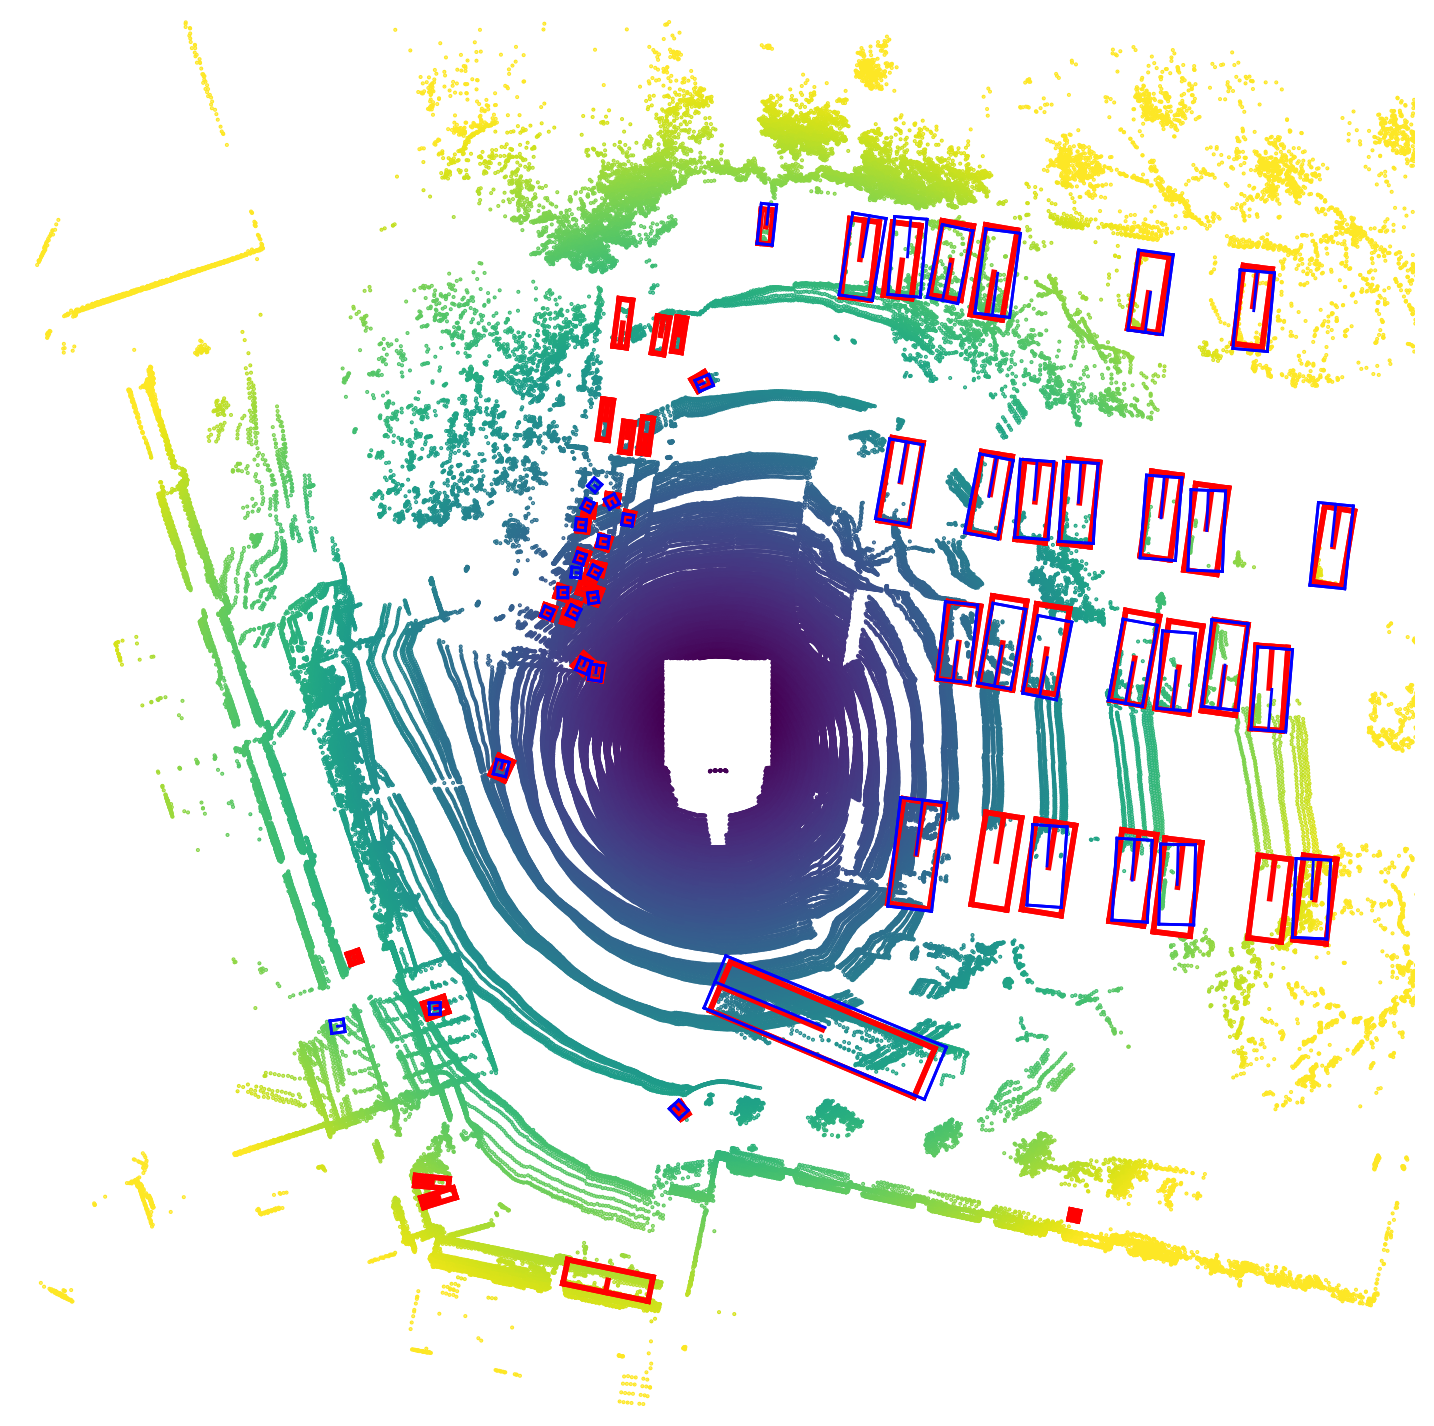

In [ ]:
vis_num = 1
draw_num = min(vis_num, len(token_list))
save_path = os.path.join(trt_work_dir, "visual")
for token in random.sample(token_list, draw_num):
    print(token)
    visual(
        copy.deepcopy(points_dict[token]),
        copy.deepcopy(gt_annos_dict[token]),
        copy.deepcopy(detections[token]),
        token, save_path=None
    )

### evaluation

In [ ]:
all_predictions = all_gather(detections)

predictions = {}
for p in all_predictions:
    predictions.update(p)

result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=trt_work_dir, testset=False)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Finish generate predictions for testset, save to work_dirs/centerpoint_pillar_pretrain/demo-mini/tensorrt/infos_val_10sweeps_withvelo_filter_True.json
Initializing nuScenes detection evaluation
Loaded results from work_dirs/centerpoint_pillar_pretrain/demo-mini/tensorrt/infos_val_10sweeps_withvelo_filter_True.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 289.82it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 15856
=> After distance based filtering: 12926
=> After LIDAR points based filtering: 12926
=> After bike rack filtering: 12861
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR points based filtering: 3393
=> After bike rack filtering: 3393
Rendering sample token b6c420c3a5bd4a219b1cb82ee5ea0aa7
Rendering sample token b22fa0b3c34f47b6a360b60f35d5d567
Rendering sample token d8251bbc2105497ab8ec80827d4429aa
Rendering sample token 372725a4b00e49c78d6d0b1c4a38b6e0
Rendering sample token ce94ef7a0522468e81c0e2b3a2f1e12d
Rendering sample token 0d0700a2284e477db876c3ee1d864668
Rendering sample token 61a7bd24f88a46c2963280d8b13ac675
Rendering sample token fa65a298c01f44e7a182bbf9e5fe3697
Rendering sample token 8573a885a7cb41d185c05029eeb9a54e
Rendering sample token 38a28a3aaf2647f2a8c0e90e31267bf8
Accumulating metric data.

## Onnx Model

### prepare data

In [40]:
onnx_data_dir = os.path.join(onnx_work_dir, "data")
os.makedirs(onnx_data_dir, exist_ok=True)

In [5]:
points_dict = {}
gt_annos_dict = {}

for i, data in tqdm(enumerate(dataset), total=len(dataset)):
    token = data['metadata']['token']
    # points_list for visualization
    points = data['points'][:, :3]
    points_dict[token] = points.T
    # gt_annos for visualization
    info = dataset._nusc_infos[i]
    gt_annos = convert_box(info)
    gt_annos_dict[token] = gt_annos
    # save points & gt for onnx
    np.savez(
        os.path.join(onnx_data_dir, f"{token}.npz"),
        points=data["points"].astype(np.float32),
        gt_annos=gt_annos
    )

100%|██████████| 81/81 [00:40<00:00,  2.00it/s]


### params

In [5]:
FEATURE_NUM = 10
MAX_PILLARS = 30000
MAX_PIONT_IN_PILLARS = 20
BEV_W = 512
BEV_H = 512
OUTPUT_W = 128
OUTPUT_H = 128

X_MIN = -51.2
X_MAX = 51.2
Y_MIN = -51.2
Y_MAX = 51.2
Z_MIN = -5.0
Z_MAX = 3.0
X_STEP = 0.2
Y_STEP = 0.2

TASK_NUM = 6
SCORE_THREAHOLD = 0.1
OUT_SIZE_FACTOR = 4.0

NMS_PRE_MAX_SIZE = 1000
NMS_POST_MAX_SIZE = 15 # TODO 83 for nusc, 15 for sim
NMS_THREAHOLD = 0.2

### preprocess & postprocess

In [6]:
def read_inputs(token):
    featureFile = f"tensorrt/data/centerpoint/feature/{token}.bin.txt"
    indicesFile = f"tensorrt/data/centerpoint/indices/{token}.bin.txt"

    with open(featureFile) as f:
        line = f.readline()
        feature = np.array([float(it) for it in line.strip().split(" ")]).reshape(
            (1, FEATURE_NUM, MAX_PILLARS, MAX_PIONT_IN_PILLARS)
        ).astype(np.float32)
    
    with open(indicesFile) as f:
        line = f.readline()
        indices = np.array([float(it) for it in line.strip().split(" ")]).reshape(
            (1, MAX_PILLARS, 2)
        ).astype(np.int64)

    return feature, indices


def preprocess(points):
    """
    Preprocess lidar points into avilable model inputs.
    
    :params
        points: np.ndarray, [num_points, dim==5]
    :return
        feature: np.ndarray, [dim==10, num_pillars, num_points_per_pillar]
        indices: np.ndarray, [num_pillars, 2]
    """
    feature = np.zeros((FEATURE_NUM, MAX_PILLARS, MAX_PIONT_IN_PILLARS), dtype=np.float32)
    indices = np.zeros((MAX_PILLARS, 2), dtype=np.int64)
    
    # delete points out of range
    range_mask = \
        (points[:, 0]>X_MIN)*(points[:, 0]<X_MAX) * \
        (points[:, 1]>Y_MIN)*(points[:, 1]<Y_MAX) * \
        (points[:, 2]>Z_MIN)*(points[:, 2]<Z_MAX)
    points = points[range_mask]
    
    # get pillars by BEV idx
    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    xIdx = ((x-X_MIN)/X_STEP).astype(np.int64)
    yIdx = ((y-Y_MIN)/Y_STEP).astype(np.int64)
    pillarIdx = yIdx*BEV_W + xIdx
    argsort_pillarIdx = pillarIdx.argsort()
    points = points[argsort_pillarIdx]
    pillarIdx = pillarIdx[argsort_pillarIdx]
    _, pointIdx = np.unique(pillarIdx, return_index=True)
    pillars = np.array(np.split(points, pointIdx[1:]), dtype=object)
    
    # sort pillars by number of points
    pointNum = np.array([pillar.shape[0] for pillar in pillars])
    argsort_pointNum = (-pointNum).argsort()
    pillars = pillars[argsort_pointNum][:MAX_PILLARS]
    pointNum = np.minimum(pointNum[argsort_pointNum][:MAX_PILLARS], MAX_PIONT_IN_PILLARS)
    pointCount = np.zeros((MAX_PILLARS), dtype=np.int64)
    pointCount[:pointNum.shape[0]] = pointNum
    
    # compute model inputs
    for i, pillar in enumerate(pillars):
        pillar_points = pillar[:MAX_PIONT_IN_PILLARS]
        num_points = pointCount[i]
        
        x, y = pillar_points[:, 0], pillar_points[:, 1]
        xIdx = ((x-X_MIN)/X_STEP).astype(np.int64)
        yIdx = ((y-Y_MIN)/Y_STEP).astype(np.int64)
        pillarIdx = yIdx*BEV_W + xIdx
        indices[i, 1] = pillarIdx[0]
        
        feature[:5, i, :num_points] = pillar_points.transpose((1,0))
        feature[8, i, :num_points] = x - (xIdx*X_STEP + X_MIN + X_STEP/2)
        feature[9, i, :num_points] = y - (yIdx*Y_STEP + Y_MIN + Y_STEP/2)
        
    valid_mask = np.arange(MAX_PIONT_IN_PILLARS)[None] < pointCount[:, None]
    centers = (feature[:3] * valid_mask).sum(-1, keepdims=True) / (valid_mask.sum(-1, keepdims=True)+1e-5)
    feature[5:8] = feature[:3] - centers
    feature *= valid_mask

    return feature[None], indices[None]


In [7]:
def _rotate_around_center(x, y, cx, cy, theta):
    cos = np.cos(theta)
    sin = np.sin(theta)
    new_x = cx + (x-cx)*cos - (y-cy)*sin
    new_y = cy + (x-cx)*sin + (y-cy)*cos
    return new_x, new_y

def _get_bev_box(box):
    x, y, w, l, theta = \
        box[:, 0], box[:, 1], box[:, 3], box[:, 4], box[:, -1]
    x1, x2 = x - w/2, x + w/2
    y1, y2 = y - l/2, y + l/2
    corners = np.array(
        [[x1, y1], [x1, y2],
         [x2, y1], [x2, y2]]
    )
    
    bev_boxes = np.zeros((corners.shape[-1], 4, 2))
    for i, cor in enumerate(corners):
        bev_boxes[:, i, 0], bev_boxes[:, i, 1] = \
            _rotate_around_center(cor[0], cor[1], x, y, -theta)
    
    return bev_boxes


def aligned_IoU_BEV(box_q, box_seq):
    max_q, min_q = box_q.max(-2), box_q.min(-2)
    max_seq, min_seq = box_seq.max(-2), box_seq.min(-2)
    
    sArea_q = (max_q[0] - min_q[0]) * (max_q[1] - min_q[1])
    sArea_seq = (max_seq[:, 0] - min_seq[:, 0]) * (max_seq[:, 1] - min_seq[:, 1])
    
    sInter_w = np.minimum(max_q[0], max_seq[:, 0]) - np.maximum(min_q[0], min_seq[:, 0])
    sInter_h = np.minimum(max_q[1], max_seq[:, 1]) - np.maximum(min_q[1], min_seq[:, 1])
    
    sInter = np.maximum(sInter_w, 0.0) * np.maximum(sInter_h, 0.0)
    sUnion = sArea_q + sArea_seq - sInter
    
    IoU = sInter / sUnion
    
    return IoU

def aligned_NMS_BEV(box_feature, box_score):
    select_idx = []
    
    bev_boxes = _get_bev_box(box_feature)
    order = (-box_score).argsort()
    order = order[:NMS_PRE_MAX_SIZE]
    
    while len(order) > 0:
        i = order[0]
        select_idx.append(i)
        if len(order) == 1:
            break
        iou = aligned_IoU_BEV(bev_boxes[i], bev_boxes[order[1:]])
        idx = (iou < NMS_THREAHOLD).nonzero()[0]
        if len(idx) == 0:
            break
        order = order[idx+1]
    select_idx = select_idx[:NMS_POST_MAX_SIZE]
    
    return select_idx


def postprocess(ort_outputs):
    """
    refer to det3d/models/bbox_heads/center_head.py
    """
    regName = ["594", "618", "642", "666", "690", "714"]
    heightName = ["598", "622", "646", "670", "694", "718"]
    rotName = ["606", "630", "654", "678", "702", "726"]
    velName = ["610", "634", "658", "682", "706", "730"]
    dimName = ["736", "738", "740", "742", "744", "746"]
    hmName = ["735", "737", "739", "741", "743", "745"]
    clsOffsetPerTask = [0, 1, 3, 5, 6, 8]
    
    final_outputs = {
        "box3d_lidar": [],
        "scores": [],
        "label_preds": []
    }
    
    for taskIdx in range(TASK_NUM):
        reg = ort_outputs[regName[taskIdx]][0]
        height = ort_outputs[heightName[taskIdx]][0]
        rot = ort_outputs[rotName[taskIdx]][0]
        vel = ort_outputs[velName[taskIdx]][0]
        dim = ort_outputs[dimName[taskIdx]][0]
        hm = ort_outputs[hmName[taskIdx]][0]
        score = np.max(hm, axis=0)
        cls = np.argmax(hm, axis=0)

        xIdx = np.arange(OUTPUT_W)[None]
        yIdx = np.arange(OUTPUT_H)[:, None]
        x = (xIdx + reg[0])*OUT_SIZE_FACTOR*X_STEP + X_MIN
        y = (yIdx + reg[1])*OUT_SIZE_FACTOR*Y_STEP + Y_MIN
        
        score_mask = (score > SCORE_THREAHOLD)
        range_mask = \
            (x>X_MIN)*(x<X_MAX)* \
            (y>Y_MIN)*(y<Y_MAX)* \
            (height[0]>Z_MIN)*(height[0]<Z_MAX)
        valid_mask = score_mask * range_mask
        
        theta = np.arctan2(rot[0], rot[1])[None]
        box_feature = np.concatenate(
            [x[None], y[None], height, dim, vel, theta], axis=0
        ).transpose((1, 2, 0))
        box_feature = box_feature[valid_mask]
        box_score = score[valid_mask]
        box_cls = cls[valid_mask] + clsOffsetPerTask[taskIdx]
        # TODO sim
        if taskIdx == 4:
            box_cls[...] = 6
        
        select_idx = aligned_NMS_BEV(
            copy.deepcopy(box_feature),
            copy.deepcopy(box_score)
        )
        
        # TODO sim
        if taskIdx not in [0, 4]:
            continue
        final_outputs["box3d_lidar"].append(box_feature[select_idx])
        final_outputs["scores"].append(box_score[select_idx])
        final_outputs["label_preds"].append(box_cls[select_idx])
        
    for k, v in final_outputs.items():
        final_outputs[k] = torch.from_numpy(np.concatenate(v, axis=0))

    return final_outputs


### inference

In [8]:
import onnxruntime
import pickle

onnx_model = 'work_dirs/centerpoint_pillar_pretrain/onnx/MatMul_Max_om/centerpoint.onnx'
ort_session = onnxruntime.InferenceSession(
    onnx_model,
    providers=[
        'CUDAExecutionProvider',
        'CPUExecutionProvider',
    ]
)

onnx_data_list = glob.glob(os.path.join(onnx_data_dir, "*.npz"))

token_list = []
detections = {}
points_dict = {}
gt_annos_dict = {}

for path in tqdm(onnx_data_list):
    token = path.split("/")[-1].split(".")[0]
    token_list.append(token)
    
    data = np.load(path, allow_pickle=True)
    points = data["points"]
    gt_annos = data["gt_annos"]
    
    feature, indices = preprocess(points)
    # feature, indices = read_inputs(token) # debug preprocess
    ort_inputs = {"input.1": feature, "indices_input": indices}
    
    output_names = [output.name for output in ort_session.get_outputs()]
    ort_outputs = ort_session.run(output_names, ort_inputs)
    ort_outputs = dict(zip(output_names, ort_outputs))
    
    final_outputs = postprocess(ort_outputs)
    final_outputs["metadata"] = {
        "token": token,
        "num_point_features": 5
    }
    
    detections.update({token: final_outputs})
    points_dict.update({token: points[:, :3].T})
    gt_annos_dict.update({token: gt_annos.item()})

with open(os.path.join(onnx_work_dir, "prediction.pkl"), "wb") as f:
    pickle.dump(detections, f)

2023-12-29 17:10:29.143929606 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'axes'. It is not used by any node and should be removed from the model.
100%|██████████| 81/81 [01:08<00:00,  1.18it/s]


### visualization

0bb62a68055249e381b039bf54b0ccf8


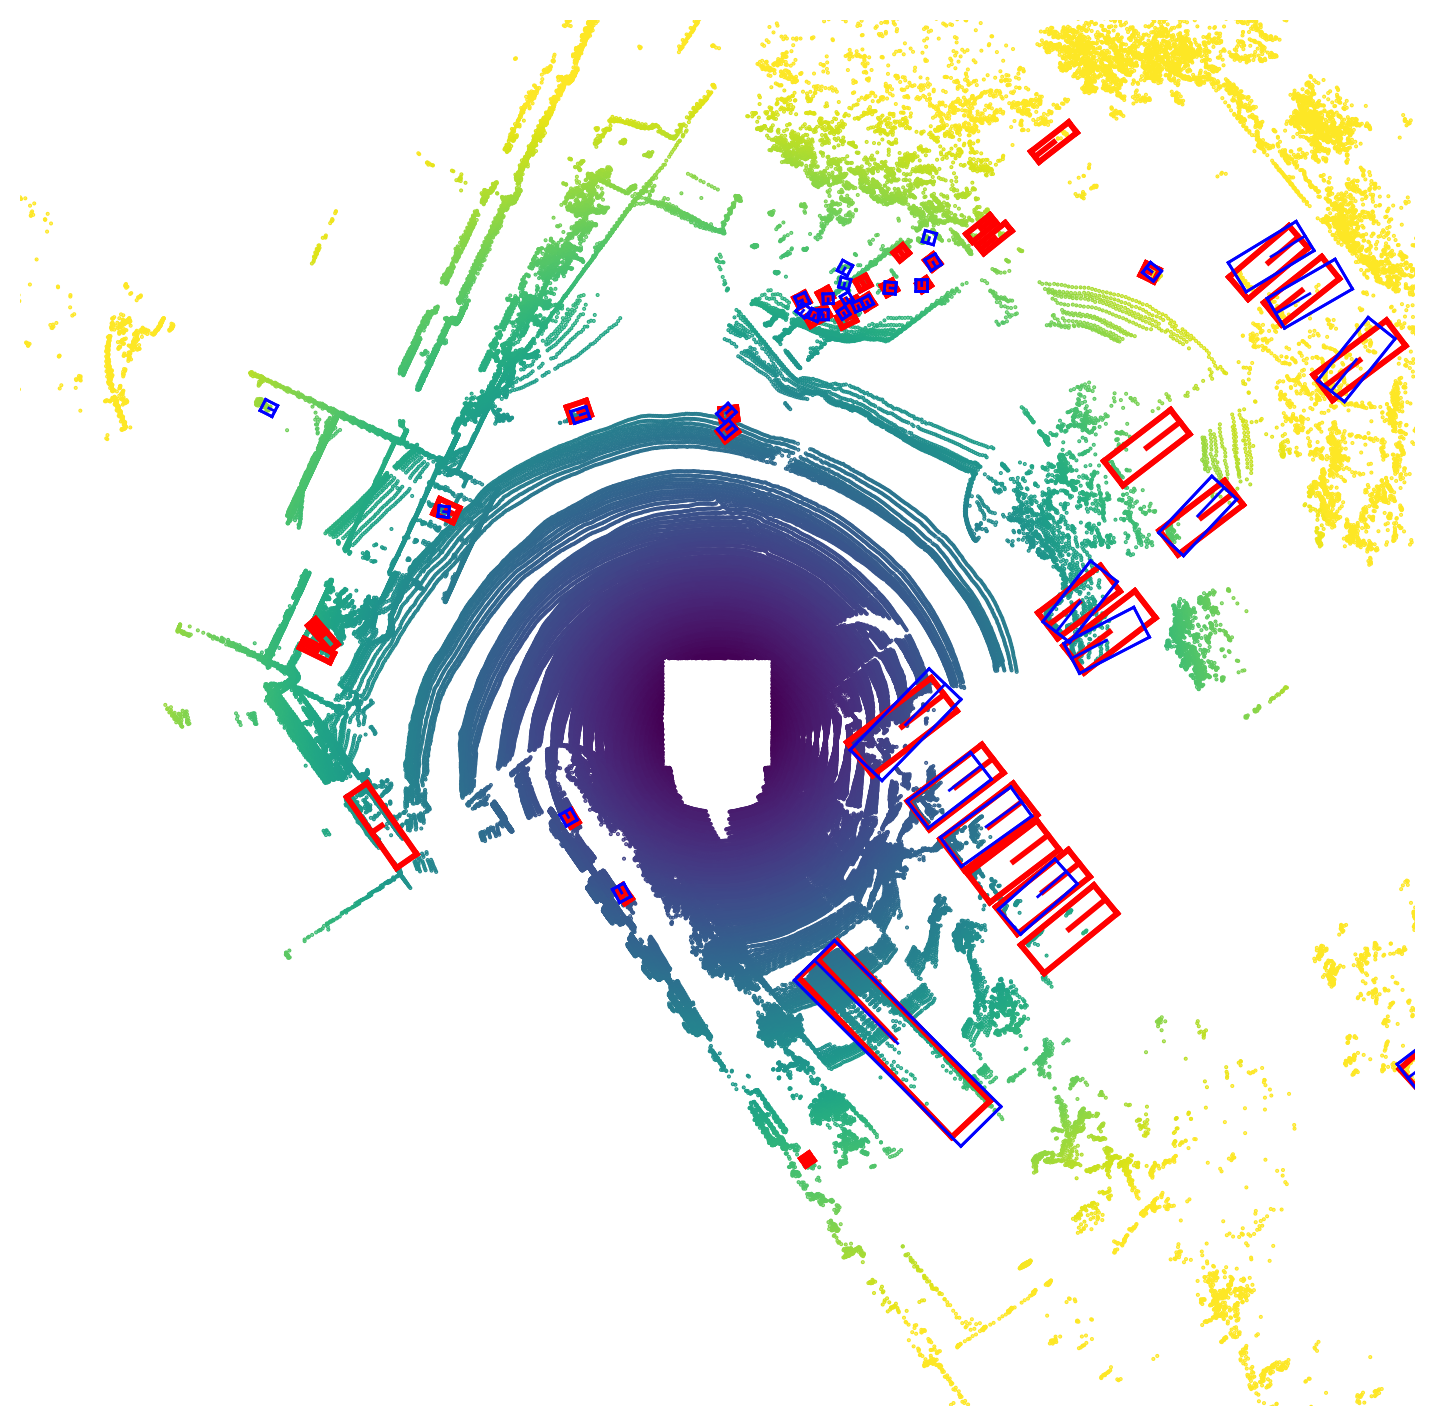

In [ ]:
vis_num = 1
draw_num = min(vis_num, len(token_list))
save_path = os.path.join(onnx_work_dir, "visual")
for token in random.sample(token_list, draw_num):
    print(token)
    visual(
        copy.deepcopy(points_dict[token]),
        copy.deepcopy(gt_annos_dict[token]),
        copy.deepcopy(detections[token]),
        token, save_path=None
    )

### evaluation

In [9]:
# all_predictions = all_gather(detections)

# predictions = {}
# for p in all_predictions:
#     predictions.update(p)

with open(os.path.join(onnx_work_dir, "prediction.pkl"), "rb") as f:
    predictions = pickle.load(f)

result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=onnx_work_dir, testset=False)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.6 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Finish generate predictions for testset, save to work_dirs/centerpoint_pillar_pretrain/demo-mini/onnx/infos_val_10sweeps_withvelo_filter_True.json
Initializing nuScenes detection evaluation
Loaded results from work_dirs/centerpoint_pillar_pretrain/demo-mini/onnx/infos_val_10sweeps_withvelo_filter_True.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 291.97it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 16279
=> After distance based filtering: 13443
=> After LIDAR points based filtering: 13443
=> After bike rack filtering: 13394
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR points based filtering: 3393
=> After bike rack filtering: 3393
Rendering sample token b6c420c3a5bd4a219b1cb82ee5ea0aa7
Rendering sample token b22fa0b3c34f47b6a360b60f35d5d567
Rendering sample token d8251bbc2105497ab8ec80827d4429aa
Rendering sample token 372725a4b00e49c78d6d0b1c4a38b6e0
Rendering sample token ce94ef7a0522468e81c0e2b3a2f1e12d
Rendering sample token 0d0700a2284e477db876c3ee1d864668
Rendering sample token 61a7bd24f88a46c2963280d8b13ac675
Rendering sample token fa65a298c01f44e7a182bbf9e5fe3697
Rendering sample token 8573a885a7cb41d185c05029eeb9a54e
Rendering sample token 38a28a3aaf2647f2a8c0e90e31267bf8
Accumulating metric data.

### tracking

In [8]:
import copy
import numpy as np


def greedy_assignment(dist):
    matched_indices = []
    if dist.shape[1] == 0:
        return np.array(matched_indices, np.int32).reshape(-1, 2)
    for i in range(dist.shape[0]):
        j = dist[i].argmin()
        if dist[i][j] < 1e16:
            dist[:, j] = 1e18
            matched_indices.append([i, j])
    return np.array(matched_indices, np.int32).reshape(-1, 2)


class Tracker(object):
    def __init__(self, max_age=0):
        self.max_age = max_age

        # 99.9 percentile of the l2 velocity error distribution (per clss / 0.5 second)
        self.CLS_VELOCITY_ERROR = {
            'car':4,
            'truck':4,
            'bus':5.5,
            'trailer':3,
            'pedestrian':1,
            'motorcycle':13,
            'bicycle':3,
        }

        self.reset()

    def reset(self):
        self.id_count = 0
        self.tracks = []

    def step_centertrack(self, detection, time_lag):
        box3d = detection["box3d_lidar"].detach().cpu().numpy()
        scores = detection["scores"].detach().cpu().numpy()
        labels = detection["label_preds"].detach().cpu().numpy()
        
        # # TODO nusc
        # from det3d.datasets.nuscenes.nusc_common import (
        #     _second_det_to_nusc_box,
        #     _lidar_nusc_box_to_global,
        # )
        # boxes = _second_det_to_nusc_box(detection)
        # boxes = _lidar_nusc_box_to_global(nusc, boxes, detection["metadata"]["token"])
        
        results = []
        for i in range(box3d.shape[0]):
            det = {}
            
            # filter out classes not evaluated for tracking
            if DETECTION_NAMES[labels[i]] not in self.CLS_VELOCITY_ERROR.keys():
                continue

            det['box3d_lidar'] = box3d[i].tolist()
            det['ct'] = copy.deepcopy(box3d[i, 0:2])
            det['tracking'] = box3d[i, 6:8] * -1 * time_lag
            det['label_preds'] = int(labels[i])
            det['detection_name'] = DETECTION_NAMES[labels[i]]
            det['detection_score'] = float(scores[i])
            
            # # TODO nusc
            # det['translation'] = boxes[i].center.tolist()
            # det['size'] = boxes[i].wlh.tolist()
            # det['rotation'] = boxes[i].orientation.elements.tolist()
            # det['velocity'] = boxes[i].velocity[:2].tolist()
            # det['ct'] = np.array(det['translation'][:2])
            # det['tracking'] = np.array(det['velocity'][:2]) * -1 * time_lag
            
            results.append(det)

        N = len(results)
        M = len(self.tracks)

        dets = np.array(
            [det['ct'] + det['tracking'] for det in results], np.float32
        ) # N x 2
        tracks = np.array([pre_det['ct'] for pre_det in self.tracks], np.float32) # M x 2
        
        item_cat = np.array([item['label_preds'] for item in results], np.int32) # N
        track_cat = np.array([track['label_preds'] for track in self.tracks], np.int32) # M

        max_diff = np.array(
            [self.CLS_VELOCITY_ERROR[box['detection_name']] for box in results],
            np.float32
        )
        
        if len(tracks) > 0:  # NOT FIRST FRAME
            dist = (((tracks.reshape(1, -1, 2) - \
                dets.reshape(-1, 1, 2)) ** 2).sum(axis=2)) # N x M
            dist = np.sqrt(dist) # absolute distance in meter

            invalid = ((dist > max_diff.reshape(N, 1)) + \
                (item_cat.reshape(N, 1) != track_cat.reshape(1, M))) > 0

            dist = dist  + invalid * 1e18
            
            matched_indices = greedy_assignment(copy.deepcopy(dist))
        else:  # first few frame
            assert M == 0
            matched_indices = np.array([], np.int32).reshape(-1, 2)

        unmatched_dets = [d for d in range(dets.shape[0]) \
            if not (d in matched_indices[:, 0])]

        unmatched_tracks = [d for d in range(tracks.shape[0]) \
            if not (d in matched_indices[:, 1])]

        ret = []
        for m in matched_indices:
            track = results[m[0]]
            track['tracking_id'] = self.tracks[m[1]]['tracking_id']      
            track['age'] = 1
            track['active'] = self.tracks[m[1]]['active'] + 1
            ret.append(track)

        for i in unmatched_dets:
            track = results[i]
            self.id_count += 1
            track['tracking_id'] = self.id_count
            track['age'] = 1
            track['active'] =  1
            ret.append(track)

        # still store unmatched tracks if its age doesn't exceed max_age, however, we shouldn't output 
        # the object in current frame 
        for i in unmatched_tracks:
            track = self.tracks[i]
            if track['age'] < self.max_age:
                track['age'] += 1
                track['active'] = 0
                ct = track['ct']

                # movement in the last second
                if 'tracking' in track:
                    offset = track['tracking'] * -1 # move forward 
                    track['ct'] = ct + offset 
                ret.append(track)

        self.tracks = ret
        return ret


In [11]:
import pickle
import json

tracker = Tracker(max_age=3)

with open(os.path.join(onnx_work_dir, "prediction.pkl"), "rb") as f:
    predictions = pickle.load(f)

frames_meta = 'work_dirs/centerpoint_pillar_pretrain/val-mini/tracking/frames_meta.json'
with open(frames_meta, 'rb') as f:
    frames = json.load(f)['frames']

nusc_annos = {
    "results": {},
    "meta": None,
}
size = len(frames)
for i in tqdm(range(size)):
    token = frames[i]['token']

    # reset tracking after one video sequence
    if frames[i]['first']:
        # use this for sanity check to ensure your token order is correct
        # print("reset ", i)
        tracker.reset()
        last_time_stamp = frames[i]['timestamp']

    time_lag = (frames[i]['timestamp'] - last_time_stamp) 
    last_time_stamp = frames[i]['timestamp']

    det = predictions[token]

    outputs = tracker.step_centertrack(det, time_lag)
    
    annos = []
    for item in outputs:
        if item['active'] == 0:
            continue 
        nusc_anno = {
            "sample_token": token,
            "box3d_lidar": item['box3d_lidar'],
            "label_preds": item['label_preds'],
            "translation": item['translation'],
            "size": item['size'],
            "rotation": item['rotation'],
            "velocity": item['velocity'],
            "tracking_id": str(item['tracking_id']),
            "tracking_name": item['detection_name'],
            "tracking_score": item['detection_score'],
        }
        annos.append(nusc_anno)
    nusc_annos["results"].update({token: annos})

nusc_annos["meta"] = {
    "use_camera": False,
    "use_lidar": True,
    "use_radar": False,
    "use_map": False,
    "use_external": False,
}

with open(os.path.join(onnx_work_dir, 'tracking_result.json'), "w") as f:
    json.dump(nusc_annos, f)


  4%|▎         | 3/81 [00:00<00:03, 21.24it/s]

100%|██████████| 81/81 [00:05<00:00, 16.10it/s]


In [12]:
from nuscenes.eval.tracking.evaluate import TrackingEval 
from nuscenes.eval.common.config import config_factory as track_configs

cfg = track_configs("tracking_nips_2019")
nusc_eval = TrackingEval(
    config=cfg,
    result_path=os.path.join(onnx_work_dir, 'tracking_result.json'),
    eval_set="mini_val",
    output_dir=onnx_work_dir,
    verbose=True,
    nusc_version="v1.0-mini",
    nusc_dataroot="data/nuScenes-mini",
)
metrics_summary = nusc_eval.main()

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.
Initializing nuScenes tracking evaluation
Loaded results from work_dirs/centerpoint_pillar_pretrain/demo-mini/onnx/tracking_result.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 267.26it/s]


Loaded ground truth annotations for 81 samples.
Filtering tracks
=> Original number of boxes: 13331
=> After distance based filtering: 11262
=> After LIDAR points based filtering: 11262
=> After bike rack filtering: 11213
Filtering ground truth tracks
=> Original number of boxes: 4402
=> After distance based filtering: 3748
=> After LIDAR points based filtering: 3358
=> After bike rack filtering: 3358
Accumulating metric data...
Computing metrics for class bicycle...



Computed thresholds



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.1390	0.000	0.501	0.780	81	41	31	9	1	1755	31	1723	1



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.1540	0.000	0.458	0.780	81	41	32	9	0	1380	32	1348	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.1889	0.000	0.458	0.780	81	41	32	9	0	678	32	646	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.1974	0.000	0.441	0.732	81	41	30	11	0	573	30	543	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.2328	0.000	0.441	0.732	79	41	30	11	0	348	30	318	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.2468	0.000	0.365	0.512	70	41	21	20	0	216	21	195	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.2489	0.000	0.365	0.512	68	41	21	20	0	193	21	172	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.3384	0.286	0.234	0.341	26	41	14	27	0	24	14	10	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5037	1.000	0.225	0.317	21	41	13	28	0	13	13	0	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5972	1.000	0.225	0.317	21	41	13	28	0	13	13	0	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6316	1.000	0.203	0.244	21	41	10	31	0	10	10	0	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7215	1.000	0.203	0.244	21	41	10	31	0	10	10	0	0

Computing metrics for class bus...



Computed thresholds



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.8397	1.000	0.253	1.000	33	33	33	0	0	33	33	0	0

Computing metrics for class car...



Computed thresholds



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.2812	0.729	0.309	0.925	81	2188	1998	164	26	2566	1998	542	26



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.3863	0.848	0.296	0.898	81	2188	1947	224	17	2259	1947	295	17



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.4104	0.874	0.292	0.877	81	2188	1905	269	14	2159	1905	240	14



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.4393	0.892	0.286	0.851	81	2188	1851	327	10	2060	1851	199	10



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.4649	0.896	0.280	0.834	81	2188	1816	364	8	2013	1816	189	8



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.4868	0.897	0.276	0.808	81	2188	1760	421	7	1949	1760	182	7



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5173	0.899	0.272	0.777	81	2188	1695	488	5	1872	1695	172	5



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5295	0.898	0.270	0.764	81	2188	1668	516	4	1842	1668	170	4



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5402	0.899	0.268	0.731	81	2188	1595	589	4	1760	1595	161	4



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5434	0.901	0.266	0.709	81	2188	1548	637	3	1705	1548	154	3



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5629	0.911	0.265	0.690	81	2188	1508	678	2	1644	1508	134	2



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5681	0.917	0.266	0.663	81	2188	1449	737	2	1571	1449	120	2



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5847	0.918	0.263	0.637	81	2188	1393	794	1	1508	1393	114	1



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5902	0.920	0.262	0.617	81	2188	1349	838	1	1458	1349	108	1



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5997	0.922	0.259	0.595	81	2188	1300	887	1	1402	1300	101	1



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6121	0.930	0.258	0.570	81	2188	1247	940	1	1335	1247	87	1



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6167	0.942	0.259	0.553	81	2188	1210	977	1	1281	1210	70	1



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6259	0.941	0.257	0.525	81	2188	1149	1039	0	1217	1149	68	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6279	0.940	0.252	0.499	81	2188	1091	1097	0	1156	1091	65	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6433	0.940	0.251	0.475	81	2188	1039	1149	0	1101	1039	62	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6473	0.940	0.251	0.458	81	2188	1003	1185	0	1063	1003	60	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6571	0.940	0.247	0.433	81	2188	948	1240	0	1005	948	57	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6609	0.951	0.241	0.409	81	2188	895	1293	0	939	895	44	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6643	0.950	0.241	0.393	81	2188	859	1329	0	902	859	43	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6729	0.954	0.242	0.359	81	2188	786	1402	0	822	786	36	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6731	0.960	0.245	0.345	81	2188	755	1433	0	785	755	30	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6747	0.957	0.229	0.312	81	2188	682	1506	0	711	682	29	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6854	0.971	0.227	0.296	81	2188	647	1541	0	666	647	19	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6887	0.970	0.224	0.272	81	2188	596	1592	0	614	596	18	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6904	0.968	0.222	0.240	81	2188	526	1662	0	543	526	17	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6972	0.968	0.223	0.226	81	2188	495	1693	0	511	495	16	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7026	0.965	0.215	0.197	81	2188	432	1756	0	447	432	15	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7047	0.980	0.220	0.183	81	2188	401	1787	0	409	401	8	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7118	0.979	0.209	0.153	81	2188	334	1854	0	341	334	7	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7164	0.974	0.207	0.125	81	2188	273	1915	0	280	273	7	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7197	0.975	0.206	0.110	81	2188	241	1947	0	247	241	6	0

Computing metrics for class motorcycle...



Computed thresholds



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.1461	0.000	0.465	0.817	81	224	161	41	22	1074	161	891	22



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.1485	0.000	0.452	0.786	81	224	160	48	16	1016	160	840	16



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.1738	0.000	0.460	0.772	81	224	157	51	16	696	157	523	16



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.1997	0.000	0.437	0.750	74	224	156	56	12	438	156	270	12



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.2614	0.483	0.412	0.688	64	224	145	70	9	229	145	75	9



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS


thr_0.3056	0.700	0.390	0.616	54	224	130	86	8	177	130	39	8



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.3101	0.750	0.355	0.540	54	224	116	103	5	150	116	29	5



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.3156	0.736	0.290	0.424	54	224	91	129	4	119	91	24	4



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.4468	0.776	0.302	0.397	54	224	85	135	4	108	85	19	4



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.4470	0.930	0.294	0.321	50	224	71	152	1	77	71	5	1



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6279	0.933	0.311	0.201	49	224	45	179	0	48	45	3	0

Computing metrics for class pedestrian...



Computed thresholds



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.2538	0.000	0.287	0.977	74	1088	1034	25	29	2308	1034	1245	29



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.2955	0.115	0.311	0.969	71	1088	1027	34	27	1963	1027	909	27



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.3234	0.335	0.288	0.960	70	1088	1020	43	25	1723	1020	678	25



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.3584	0.452	0.297	0.949	70	1088	1010	55	23	1586	1010	553	23



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.3912	0.581	0.295	0.917	70	1088	977	90	21	1407	977	409	21



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.4184	0.685	0.301	0.907	68	1088	967	101	20	1292	967	305	20



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.4496	0.755	0.313	0.903	68	1088	961	105	22	1218	961	235	22



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.4720	0.817	0.302	0.876	65	1088	938	135	15	1125	938	172	15



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5089	0.875	0.355	0.854	65	1088	914	159	15	1043	914	114	15



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5646	0.942	0.331	0.815	65	1088	872	201	15	938	872	51	15



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.5930	0.944	0.302	0.782	65	1088	841	237	10	898	841	47	10



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6336	0.955	0.320	0.752	65	1088	808	270	10	854	808	36	10



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6484	0.959	0.290	0.710	65	1088	765	315	8	804	765	31	8



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6562	0.964	0.285	0.678	65	1088	731	350	7	764	731	26	7



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6606	0.965	0.285	0.658	65	1088	709	372	7	741	709	25	7



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6692	0.967	0.265	0.642	65	1088	691	390	7	721	691	23	7



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6728	0.966	0.267	0.621	65	1088	669	412	7	699	669	23	7



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6779	0.967	0.243	0.593	65	1088	638	443	7	666	638	21	7



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6862	0.975	0.270	0.583	65	1088	628	454	6	650	628	16	6



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6893	0.987	0.317	0.553	65	1088	598	486	4	610	598	8	4



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6972	0.987	0.329	0.506	65	1088	547	537	4	558	547	7	4



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7147	0.990	0.319	0.485	65	1088	526	560	2	533	526	5	2



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7181	0.994	0.277	0.455	65	1088	493	593	2	498	493	3	2



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7267	0.993	0.232	0.415	65	1088	451	637	0	454	451	3	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7333	0.993	0.197	0.391	65	1088	425	663	0	428	425	3	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7403	0.993	0.201	0.374	65	1088	407	681	0	410	407	3	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7449	0.992	0.155	0.340	65	1088	370	718	0	373	370	3	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7478	0.994	0.159	0.310	65	1088	337	751	0	339	337	2	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7530	0.994	0.159	0.308	65	1088	335	753	0	337	335	2	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7572	0.997	0.165	0.268	65	1088	292	796	0	293	292	1	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7588	0.996	0.153	0.241	65	1088	262	826	0	263	262	1	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7597	0.996	0.147	0.231	65	1088	251	837	0	252	251	1	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7601	1.000	0.146	0.208	65	1088	226	862	0	226	226	0	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7629	1.000	0.113	0.192	65	1088	209	879	0	209	209	0	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7638	1.000	0.113	0.167	65	1088	182	906	0	182	182	0	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7657	1.000	0.112	0.143	65	1088	156	932	0	156	156	0	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7757	1.000	0.105	0.106	65	1088	115	973	0	115	115	0	0

Computing metrics for class trailer...

Computing metrics for class truck...



Computed thresholds



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.2683	0.518	0.196	0.905	65	95	85	9	1	127	85	41	1



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.2855	0.588	0.185	0.842	64	95	80	15	0	113	80	33	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.3179	0.788	0.185	0.842	64	95	80	15	0	97	80	17	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.3218	0.738	0.161	0.684	64	95	65	30	0	82	65	17	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.3235	0.738	0.161	0.684	64	95	65	30	0	82	65	17	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6715	1.000	0.159	0.653	57	95	62	33	0	62	62	0	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.6806	1.000	0.137	0.263	57	95	25	70	0	25	25	0	0



		MOTAR	MOTP	Recall	Frames	GT	GT-Mtch	GT-Miss	GT-IDS	Pred	Pred-TP	Pred-FP	Pred-IDS
thr_0.7306	1.000	0.137	0.263	57	95	25	70	0	25	25	0	0

Calculating metrics...
Saving metrics to: work_dirs/centerpoint_pillar_pretrain/demo-mini/onnx

### Final results ###

Per-class results:
		AMOTA	AMOTP	RECALL	MOTAR	GT	MOTA	MOTP	MT	ML	FAF	TP	FP	FN	IDS	FRAG	TID	LGD
bicycle 	0.282	0.791	0.317	1.000	41	0.317	0.225	2	5	0.0	13	0	28	0	0	0.25	0.25
bus     	1.000	0.253	1.000	1.000	33	1.000	0.253	1	0	0.0	33	0	0	0	0	0.00	0.00
car     	0.835	0.426	0.877	0.874	2188	0.761	0.292	87	18	296.3	1905	240	269	14	18	0.37	0.65
motorcy 	0.469	0.848	0.616	0.700	224	0.406	0.390	6	3	72.2	130	39	86	8	4	0.36	1.57
pedestr 	0.803	0.375	0.815	0.942	1088	0.755	0.331	45	21	78.5	872	51	201	15	3	0.35	0.48
trailer 	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
truck   	0.796	0.391	0.842	0.788	95	0.663	0.185	2	0	26.6	80	17	15	0	0	1.50	1.62

Aggregated results:
AMOTA	0.697
AMOTP	0.514
RECALL	0.745
MOTAR	0.884
GT	611


In [48]:
import json
from collections import OrderedDict

eval_names = [
    'car',
    'truck',
    'bus',
    'trailer',
    'motorcycle',
    'bicycle',
    'pedestrian',
]

eval_types = [DETECTION_NAMES.index(name) for name in eval_names]

thres_list = [0.5, 1.0, 2.0, 4.0]

result_path = os.path.join(onnx_work_dir, 'tracking_result.json')
with open(result_path, 'rb') as f:
    results = json.load(f)['results']

frames_meta = 'work_dirs/centerpoint_pillar_pretrain/val-mini/tracking/frames_meta.json'
with open(frames_meta, 'rb') as f:
    frames = json.load(f)['frames']
    
gt_annos_series = []
gt_annos_dict = None
size = len(frames)
for i in tqdm(range(size)):
    token = frames[i]['token']
    
    if frames[i]['first']:
        if gt_annos_dict is not None:
            gt_annos_series.append(gt_annos_dict)
        gt_annos_dict = OrderedDict()
        
    data_path = os.path.join(onnx_data_dir, f"{token}.npz")
    data = np.load(data_path, allow_pickle=True)
    gt_annos = data["gt_annos"]
    gt_annos_dict.update({token: gt_annos.item()})
gt_annos_series.append(gt_annos_dict)

amota_types = []
amotp_types = []
for label in eval_types:
    gt_boxes_series = []
    gt_ids_series = []
    pred_boxes_series = []
    pred_ids_series = []
    pred_scores_series = []
    for gt_annos_dict in gt_annos_series:
        gt_boxes = []
        gt_ids = []
        pred_boxes = []
        pred_ids = []
        pred_scores = []
        for token in gt_annos_dict.keys():
            sample_gts = gt_annos_dict[token]
            sample_preds = results[token]
            
            gt_boxes.append(sample_gts["box3d_lidar"][sample_gts["label_preds"]==label])
            gt_ids.append(sample_gts["tracking_ids"][sample_gts["label_preds"]==label])
            
            sample_boxes = [
                np.array(pred["box3d_lidar"]) \
                    for pred in sample_preds if pred["label_preds"]==label
            ]
            if len(sample_boxes) == 0:
                pred_boxes.append(np.zeros((0, 9)))
            else:
                pred_boxes.append(np.stack(sample_boxes))
                
            sample_ids = np.array([
                pred["tracking_id"] \
                    for pred in sample_preds if pred["label_preds"]==label
            ])
            pred_ids.append(sample_ids)
            
            sample_scores = np.array([
                pred["tracking_score"] \
                    for pred in sample_preds if pred["label_preds"]==label
            ])
            pred_scores.append(sample_scores)
            
        gt_boxes_series.append(gt_boxes)
        gt_ids_series.append(gt_ids)
        pred_boxes_series.append(pred_boxes)
        pred_ids_series.append(pred_ids)
        pred_scores_series.append(pred_scores)

    amota_thres = []
    amotp_thres = []
    for thres in thres_list:
        amota, amotp = cal_amot(gt_boxes_series, gt_ids_series, pred_boxes_series, pred_ids_series, pred_scores_series, thres)
        amota_thres.append(amota)
        amotp_thres.append(amotp)
        print(f"[type{label}] AMOTA@{thres}: {amota} | AMOTP@{thres}: {amotp}")
    mean_amota = np.mean(amota_thres)
    mean_amotp = np.mean(amotp_thres)
    print(f"[type{label}] AMOTA@{thres_list}: {mean_amota} | AMOTP@{thres_list}: {mean_amotp}")
    amota_types.append(mean_amota)
    amotp_types.append(mean_amotp)
AMOTA = np.nanmean(amota_types)
AMOTP = np.nanmean(amotp_types)
print(f"[total] AMOTA: {AMOTA} | AMOTP: {AMOTP}")

100%|██████████| 81/81 [00:00<00:00, 1850.87it/s]


[type0] AMOTA@0.5: 0.710900579810021 | AMOTP@0.5: 0.15529853793454018
[type0] AMOTA@1.0: 0.8027175160553393 | AMOTP@1.0: 0.21518759605913557
[type0] AMOTA@2.0: 0.8270768297107798 | AMOTP@2.0: 0.2706991741120348
[type0] AMOTA@4.0: 0.835167781219973 | AMOTP@4.0: 0.33625897378846437
[type0] AMOTA@[0.5, 1.0, 2.0, 4.0]: 0.7939656766990283 | AMOTP@[0.5, 1.0, 2.0, 4.0]: 0.24436107047354375
[type1] AMOTA@0.5: 0.4933938058462499 | AMOTP@0.5: 0.11641748043445721
[type1] AMOTA@1.0: 0.5009697870676824 | AMOTP@1.0: 0.12536693819457734
[type1] AMOTA@2.0: 0.5088849581881142 | AMOTP@2.0: 0.15018514921647447
[type1] AMOTA@4.0: 0.5177863085888295 | AMOTP@4.0: 0.23452834884697518
[type1] AMOTA@[0.5, 1.0, 2.0, 4.0]: 0.505258714922719 | AMOTP@[0.5, 1.0, 2.0, 4.0]: 0.15662447917312106
[type3] AMOTA@0.5: 0.8046968972363521 | AMOTP@0.5: 0.19291093625118577
[type3] AMOTA@1.0: 0.8773712737127372 | AMOTP@1.0: 0.22512785331214596
[type3] AMOTA@2.0: 0.8773712737127372 | AMOTP@2.0: 0.22512785331214596
[type3] AMOTA

/home/linlongzhong/anaconda3/envs/centerpoint/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


[type6] AMOTA@0.5: 0.3573155429346253 | AMOTP@0.5: 0.14265440764482323
[type6] AMOTA@1.0: 0.3742115394170689 | AMOTP@1.0: 0.2118794635853202
[type6] AMOTA@2.0: 0.3728747698226133 | AMOTP@2.0: 0.2570098980638638
[type6] AMOTA@4.0: 0.385582069795011 | AMOTP@4.0: 0.3040821071214076
[type6] AMOTA@[0.5, 1.0, 2.0, 4.0]: 0.3724959804923296 | AMOTP@[0.5, 1.0, 2.0, 4.0]: 0.22890646910385373
[type7] AMOTA@0.5: 0.24779040404040403 | AMOTP@0.5: 0.13584810207504813
[type7] AMOTA@1.0: 0.24779040404040403 | AMOTP@1.0: 0.19038535523288913
[type7] AMOTA@2.0: 0.24779040404040403 | AMOTP@2.0: 0.3163138940273048
[type7] AMOTA@4.0: 0.24779040404040403 | AMOTP@4.0: 0.4959946984020737
[type7] AMOTA@[0.5, 1.0, 2.0, 4.0]: 0.24779040404040403 | AMOTP@[0.5, 1.0, 2.0, 4.0]: 0.28463551243432894
[type8] AMOTA@0.5: 0.6980736800928256 | AMOTP@0.5: 0.13050632506039517
[type8] AMOTA@1.0: 0.6989763487848648 | AMOTP@1.0: 0.1489300716361373
[type8] AMOTA@2.0: 0.6997440005613538 | AMOTP@2.0: 0.16502507928646437
[type8] AMO

### simulation test

In [9]:
def pcd_to_points(pcd):
    points = np.zeros((pcd.shape[0], 5), dtype=np.float32)
    points[:, :pcd.shape[1]] = pcd
    return points

def bbx_to_gt(bbx, token):
    gt_annos = {
        "box3d_lidar": np.zeros((bbx.shape[0], 9)),
        "scores": np.ones(bbx.shape[0]),
        "label_preds": bbx[:, 7].astype(np.long),
        "tracking_ids": bbx[:, 8].astype(np.str),
        "metadata": {"token":token, "num_point_features":5}
    }
    gt_annos["box3d_lidar"][:, :3] = bbx[:, :3]
    gt_annos["box3d_lidar"][:, 3:6] = bbx[:, [5,4,6]]
    gt_annos["box3d_lidar"][:, -1] = bbx[:, 3] - np.pi/2
    gt_annos["label_preds"][gt_annos["label_preds"]==1] = 0
    gt_annos["label_preds"][gt_annos["label_preds"]==2] = 6
    gt_annos["label_preds"][gt_annos["label_preds"]==3] = 6
    return gt_annos


In [10]:
import time
import onnxruntime

onnx_model = 'work_dirs/centerpoint_pillar_pretrain/onnx/MatMul_Max_om/centerpoint.onnx'
ort_session = onnxruntime.InferenceSession(
    onnx_model,
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)

tracker = Tracker(max_age=3)

episode_id = 2
num_samples = 100
timesteps = [10*(i+1) for i in range(num_samples)]
sim_pcd_list = [f"/nas_data/llz/carla/new/raw_data/episode_{episode_id}/pcd_{t}.npy" for t in timesteps]
sim_bbx_list = [f"/nas_data/llz/carla/new/raw_data/episode_{episode_id}/bbx_{t}.npy" for t in timesteps]

token_list = []
detections = {}
points_dict = {}
gt_annos_dict = {}
time_list = []
first_frame = True
tracking_results = {}

for pcd_path, bbx_path in tqdm(zip(sim_pcd_list, sim_bbx_list), total=len(sim_pcd_list)):
    token = "/".join(pcd_path.split(".")[0].split("/")[-2:])
    token_list.append(token)
    
    pcd = np.load(pcd_path)
    bbx = np.load(bbx_path)
    
    points = pcd_to_points(pcd)
    gt_annos = bbx_to_gt(bbx, token)
    
    feature, indices = preprocess(points)
    ort_inputs = {"input.1": feature, "indices_input": indices}

    output_names = [output.name for output in ort_session.get_outputs()]
    t_start = time.time()
    ort_outputs = ort_session.run(output_names, ort_inputs)
    t_end = time.time()
    inference_time = t_end - t_start
    ort_outputs = dict(zip(output_names, ort_outputs))
    
    final_outputs = postprocess(ort_outputs)
    final_outputs["metadata"] = {
        "token": token,
        "num_point_features": 5
    }
    
    if first_frame:
        tracker.reset()
        first_frame = False
    
    track_outputs = tracker.step_centertrack(final_outputs, time_lag=0.5)
    annos = []
    for item in track_outputs:
        if item['active'] == 0:
            continue 
        anno_dict = {
            "sample_token": token,
            "box3d_lidar": item['box3d_lidar'],
            "label_preds": item['label_preds'],
            "tracking_id": str(item['tracking_id']),
            "tracking_name": item['detection_name'],
            "tracking_score": item['detection_score'],
        }
        annos.append(anno_dict)
    
    detections.update({token: final_outputs})
    tracking_results.update({token: annos})
    points_dict.update({token: points[:, :3].T})
    gt_annos_dict.update({token: gt_annos})
    time_list.append(inference_time)
    

2024-01-17 21:09:03.257811204 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'axes'. It is not used by any node and should be removed from the model.
100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


In [10]:
print("avg_time:", np.mean(time_list))

avg_time: 0.18499895334243774


episode_2/pcd_830


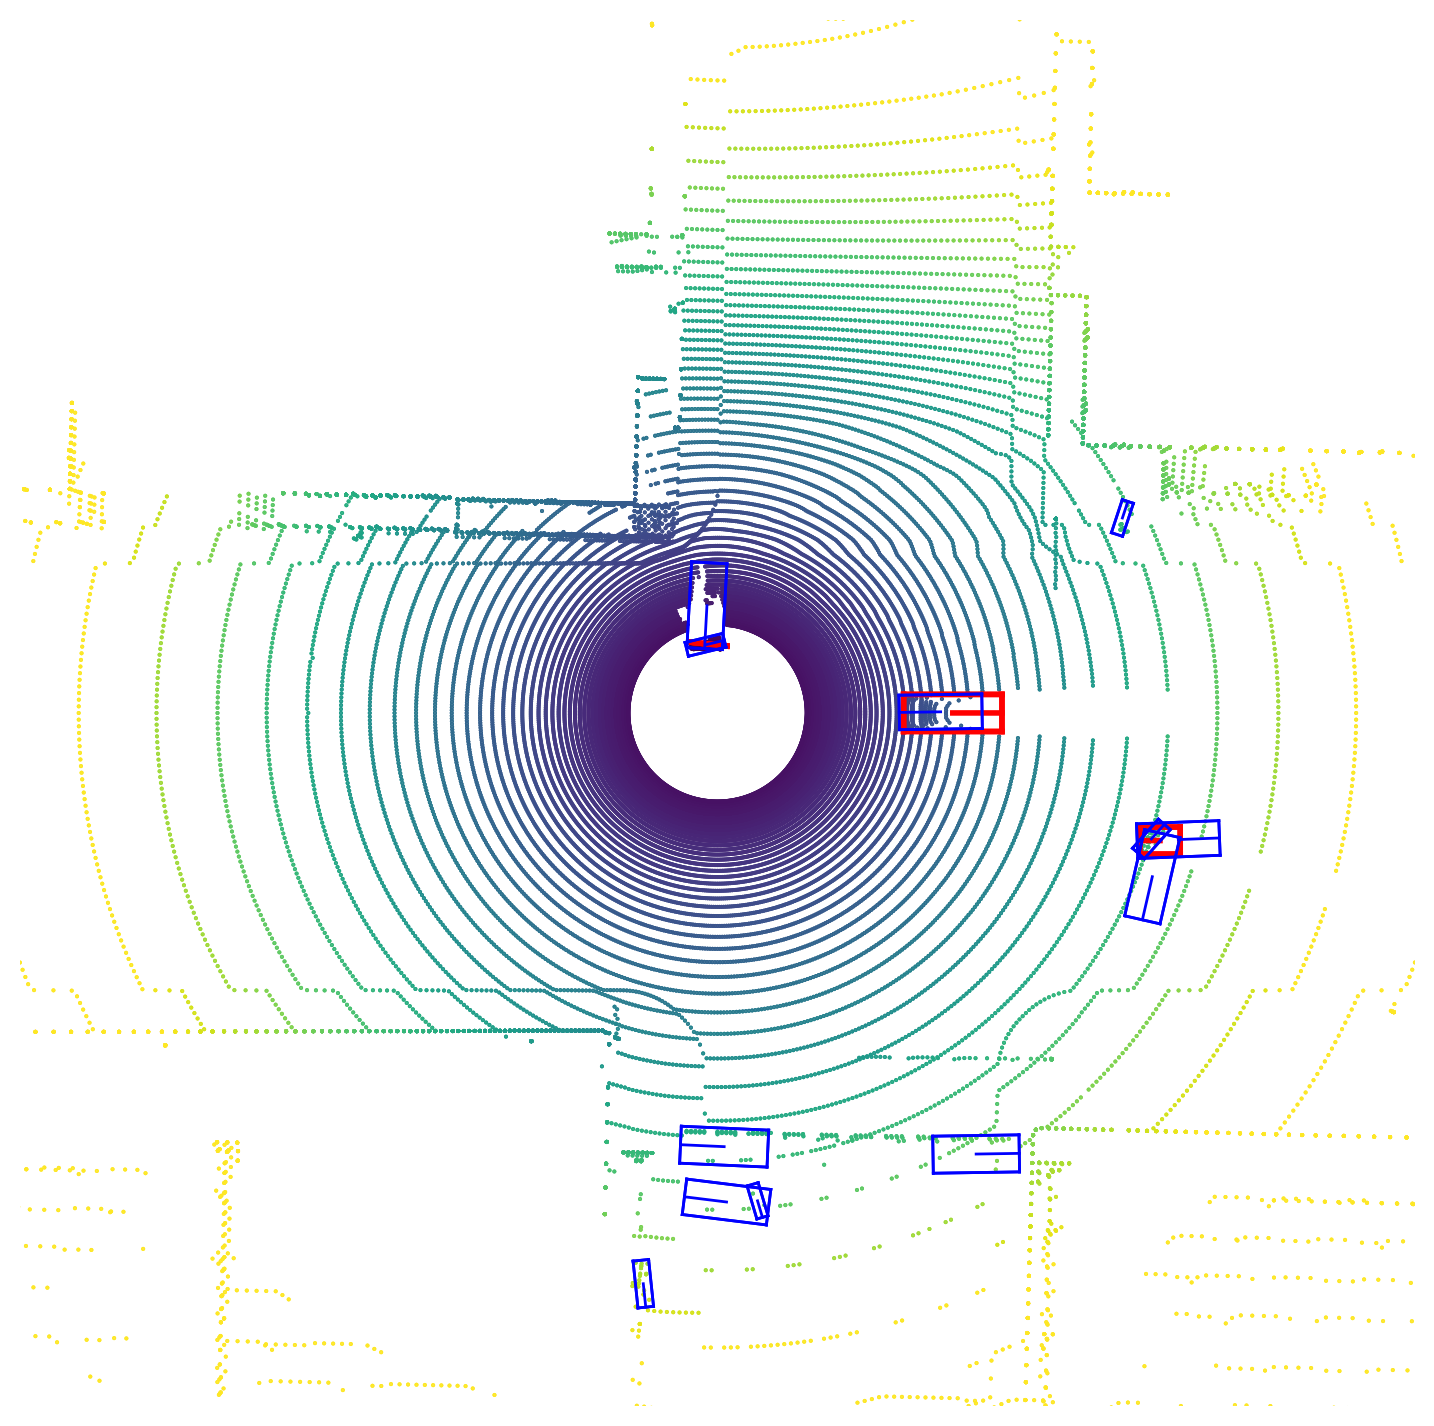

In [11]:
vis_num = 1
draw_num = min(vis_num, len(token_list))
for token in random.sample(token_list, draw_num):
    print(token)
    visual(
        copy.deepcopy(points_dict[token]),
        copy.deepcopy(gt_annos_dict[token]),
        copy.deepcopy(detections[token]),
        token, save_path=None,
        conf_th=0.0
    )

In [11]:
def dis_bev(boxes_a, boxes_b):
    """Compute BEV distance between input box sequences.
    
    :params
        boxes_a: [n, dim==9]
        boxes_b: [m, dim==9]
    
    :return:
        distance matrix: [n, m]
    """
    
    boxes_a_xy = np.expand_dims(boxes_a, axis=1)[..., :2] # [n, 1, 2]
    boxes_b_xy = np.expand_dims(boxes_b, axis=0)[..., :2] # [1, m, 2]

    distance = np.linalg.norm(boxes_a_xy - boxes_b_xy, axis=-1) # [n, m]
    return distance


def pr_to_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    
    :params
        recall: The recall curve (list).
        precision: The precision curve (list).
    
    :return:
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def cal_ap(gt_boxes, pred_boxes, pred_scores, threshold):
    """
    Calculate AP (Average Precision) under specific object type and threshold.
    
    :params
        gt_boxes: list of 2d array with shape [num_gts, dim==9]
        pred_boxes: list of 2d array with shape [num_preds, dim==9]
        pred_scores: list of 1d array with shape [num_preds]
        threshold: float, bound for distinguishing positives
        
    :return
        the AP value
    """
    
    ## sort predictions by score
    score_seq = [(-sample_scores).argsort() for sample_scores in pred_scores]
    pred_boxes = [sample_boxes[mask] for sample_boxes, mask in zip(pred_boxes, score_seq)]
    pred_scores = [sample_scores[mask] for sample_scores, mask in zip(pred_scores, score_seq)]
    
    ## count false & true positives
    fp = np.zeros((0,))
    tp = np.zeros((0,))
    scores = np.zeros((0,))
    total_gts = 0
    # loop for each sample
    for sample_gts, sample_pred_boxes, sample_scores in zip(gt_boxes, pred_boxes, pred_scores):
        total_gts = total_gts + len(sample_gts)
        assigned_gt = []  # one gt can only be assigned to one predicted bbox
        # loop for each predicted bbox
        for pred_box, score in zip(sample_pred_boxes, sample_scores):
            scores = np.append(scores, score)
            if len(sample_gts) == 0:  # if no gts found for the predicted bbox, assign the bbox to fp
                fp = np.append(fp, 1)
                tp = np.append(tp, 0)
                continue
            pred_box = np.expand_dims(pred_box, axis=0)
            dis = dis_bev(sample_gts, pred_box)
            gt_for_box = np.argmin(dis, axis=0)
            min_dis = dis[gt_for_box, 0]
            if min_dis <= threshold and gt_for_box not in assigned_gt:
                fp = np.append(fp, 0)
                tp = np.append(tp, 1)
                assigned_gt.append(gt_for_box)
            else:
                fp = np.append(fp, 1)
                tp = np.append(tp, 0)
    # sort by score
    indices = np.argsort(-scores)
    fp = fp[indices]
    tp = tp[indices]
    # compute cumulative false positives and true positives
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    
    ## compute recall and precision
    recall = tp / total_gts
    precision = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    
    ## compute AP from PR curve
    ap = pr_to_ap(recall, precision)
    
    return ap


In [47]:
def cal_amot(
    gt_boxes_series, gt_ids_series,
    pred_boxes_series, pred_ids_series,
    pred_scores_series, threshold
):
    """
    Calculate AMOTA (average multi object tracking accuracy) and \
        AMOTP (average multi object tracking precision) for tracking.

    :param
        gt_boxes_series: multiple time series of 2d arrays with shape [num_gts, dim==9]
        gt_ids_series: multiple time series of 1d arrays with shape [num_gts]
        pred_boxes_series: multiple time series of 2d arrays with shape [num_preds, dim==9]
        pred_ids_series: multiple time series of 1d arrays with shape [num_preds]
        pred_scores_series: multiple time series of 1d arrays with shape [num_preds]
        threshold: The threshold for calculating MOTA.

    :return
        The AMOTA and AMOTP for the given threshold.
    """
    # initialize counters
    GT = 0  # ground truth objects
    fp = np.zeros((0,))  # false positives
    tp = np.zeros((0,))  # true positives
    ids = np.zeros((0,))  # ID switches
    dist = np.zeros((0,))  # distance of TPs
    scores = np.zeros((0,))  # Score of predictions

    for gt_boxes, gt_ids, pred_boxes, pred_ids, pred_scores in zip(
        gt_boxes_series, gt_ids_series,
        pred_boxes_series, pred_ids_series,
        pred_scores_series
    ):
        # Initialize dictionary for tracking ID matches
        id_matches = {}
        
        # sort predictions by score
        score_seq = [(-sample_scores).argsort() for sample_scores in pred_scores]
        pred_boxes = [sample_boxes[mask] for sample_boxes, mask in zip(pred_boxes, score_seq)]
        pred_scores = [sample_scores[mask] for sample_scores, mask in zip(pred_scores, score_seq)]

        for t in range(len(gt_boxes)):
            gts_t = gt_boxes[t]
            gt_ids_t = gt_ids[t]
            preds_t = pred_boxes[t]
            pred_ids_t = pred_ids[t]
            pred_scores_t = pred_scores[t]
            
            GT += len(gts_t)
            assigned_gt = []  # one gt can only be assigned to one predicted bbox
            # loop for each predicted bbox
            for pred_box, pred_id, score in zip(preds_t, pred_ids_t, pred_scores_t):
                scores = np.append(scores, score)
                if len(gts_t) == 0:  # if no gts found for the predicted bbox, assign the bbox to fp
                    fp = np.append(fp, 1)
                    tp = np.append(tp, 0)
                    ids = np.append(ids, 0)
                    dist = np.append(dist, 0)
                    continue
                pred_box = np.expand_dims(pred_box, axis=0)
                dis = dis_bev(gts_t, pred_box)
                gt_for_box = np.argmin(dis, axis=0)
                min_dis = dis[gt_for_box, 0]
                if min_dis <= threshold and gt_for_box not in assigned_gt:
                    assigned_gt.append(gt_for_box)
                    fp = np.append(fp, 0)
                    tp = np.append(tp, 1)
                    dist = np.append(dist, min_dis)
                    # compute ID switches
                    gt_idx = gt_for_box[0]
                    if gt_ids_t[gt_idx] in id_matches \
                    and id_matches[gt_ids_t[gt_idx]] != pred_id:
                        ids = np.append(ids, 1)
                    else:
                        ids = np.append(ids, 0)
                    id_matches[gt_ids_t[gt_idx]] = pred_id
                else:
                    fp = np.append(fp, 1)
                    tp = np.append(tp, 0)
                    ids = np.append(ids, 0)
                    dist = np.append(dist, 0)
    # sort by score
    indices = np.argsort(-scores)
    fp = fp[indices]
    tp = tp[indices]
    ids = ids[indices]
    dist = dist[indices]
    # compute cumulative metrics
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    ids = np.cumsum(ids)
    dist = np.cumsum(dist)
    
    # compute recall
    recall = tp / GT

    # compute MOTA & MOTP
    mota = np.maximum(0, 1 - (fp + ids) / np.maximum(tp, np.finfo(np.float64).eps))
    motp = dist / np.maximum(tp, np.finfo(np.float64).eps)
    
    # compute AMOTA & AMOTP
    AMOTA = pr_to_ap(recall, mota)
    AMOTP = pr_to_ap(recall, motp)
    
    return AMOTA, AMOTP


In [38]:
sim_work_dir = 'work_dirs/centerpoint_pillar_pretrain/carla/new'
os.makedirs(sim_work_dir, exist_ok=True)
output_file = open(os.path.join(sim_work_dir, f"results_{episode_id}.txt"), 'w')

eval_types = [0, 6]
thres_list = [0.5, 1.0, 2.0, 4.0]

ap_types = []
for label in eval_types:
    gt_boxes = []
    pred_boxes = []
    pred_scores = []
    for token in token_list:
        sample_gts = gt_annos_dict[token]
        sample_preds = detections[token]
        gt_boxes.append(sample_gts["box3d_lidar"][sample_gts["label_preds"]==label])
        pred_boxes.append(sample_preds["box3d_lidar"][sample_preds["label_preds"]==label].numpy())
        pred_scores.append(sample_preds["scores"][sample_preds["label_preds"]==label].numpy())
    
    ap_thres = []
    for thres in thres_list:
        ap = cal_ap(gt_boxes, pred_boxes, pred_scores, thres)
        ap_thres.append(ap)
        print(f"[type{label}] AP@{thres}:", ap, file=output_file)
    ap = np.mean(ap_thres)
    print(f"[type{label}] AP@{thres_list}:", ap, file=output_file)
    ap_types.append(ap)

mAP = np.mean(ap_types)
print("[total] mAP:", mAP, file=output_file)
output_file.close()

print("mAP:", mAP)

mAP: 0.4425363716605082


In [37]:
sim_work_dir = 'work_dirs/centerpoint_pillar_pretrain/carla/new'
os.makedirs(sim_work_dir, exist_ok=True)
output_file = open(os.path.join(sim_work_dir, f"tracking_results_{episode_id}.txt"), 'w')

eval_types = [0, 6]
thres_list = [0.5, 1.0, 2.0, 4.0]

amota_types = []
amotp_types = []
for label in eval_types:
    gt_boxes = []
    gt_ids = []
    pred_boxes = []
    pred_ids = []
    pred_scores = []
    for token in token_list:
        sample_gts = gt_annos_dict[token]
        sample_preds = tracking_results[token]
        
        gt_boxes.append(sample_gts["box3d_lidar"][sample_gts["label_preds"]==label])
        gt_ids.append(sample_gts["tracking_ids"][sample_gts["label_preds"]==label])
        
        sample_boxes = [
            np.array(pred["box3d_lidar"]) \
                for pred in sample_preds if pred["label_preds"]==label
        ]
        if len(sample_boxes) == 0:
            pred_boxes.append(np.zeros((0, 9)))
        else:
            pred_boxes.append(np.stack(sample_boxes))
            
        sample_ids = np.array([
            pred["tracking_id"] \
                for pred in sample_preds if pred["label_preds"]==label
        ])
        pred_ids.append(sample_ids)
        
        sample_scores = np.array([
            pred["tracking_score"] \
                for pred in sample_preds if pred["label_preds"]==label
        ])
        pred_scores.append(sample_scores)
        
    gt_boxes_series = [gt_boxes]
    gt_ids_series = [gt_ids]
    pred_boxes_series = [pred_boxes]
    pred_ids_series = [pred_ids]
    pred_scores_series = [pred_scores]

    amota_thres = []
    amotp_thres = []
    for thres in thres_list:
        amota, amotp = cal_amot(gt_boxes_series, gt_ids_series, pred_boxes_series, pred_ids_series, pred_scores_series, thres)
        amota_thres.append(amota)
        amotp_thres.append(amotp)
        print(f"[type{label}] AMOTA@{thres}: {amota} | AMOTP@{thres}: {amotp}", file=output_file)
    mean_amota = np.mean(amota_thres)
    mean_amotp = np.mean(amotp_thres)
    print(f"[type{label}] AMOTA@{thres_list}: {mean_amota} | AMOTP@{thres_list}: {mean_amotp}", file=output_file)
    amota_types.append(mean_amota)
    amotp_types.append(mean_amotp)
AMOTA = np.nanmean(amota_types)
AMOTP = np.nanmean(amotp_types)
print(f"[total] AMOTA: {AMOTA} | AMOTP: {AMOTP}", file=output_file)
print(f"AMOTA: {AMOTA} | AMOTP: {AMOTP}")

AMOTA: 0.39256865254070195 | AMOTP: 0.13359937241482267


## OM Model

### val-mini

In [5]:
import pickle

om_work_dir = "work_dirs/centerpoint_pillar_pretrain/val-mini/om"

results_dir = os.path.join(om_work_dir, "predictions")
results_list = glob.glob(os.path.join(results_dir, "prediction_*-*.pkl"))
predictions = {}
for result_path in results_list:    
    with open(result_path, "rb") as f:
        predictions.update(pickle.load(f))

print("number of predictions:", len(predictions))

for token, output in predictions.items():
    for k, v in output.items():
        if isinstance(v, np.ndarray):
            output[k] = torch.from_numpy(v)

dataset = build_dataset(cfg.data.val)
result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=om_work_dir, testset=False)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

number of predictions: 81
10
Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Finish generate predictions for testset, save to work_dirs/centerpoint_pillar_pretrain/val-mini/om/infos_val_10sweeps_withvelo_filter_True.json
Initializing nuScenes detection evaluation
Loaded results from work_dirs/centerpoint_pillar_pretrain/val-mini/om/infos_val_10sweeps_withvelo_filter_True.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 332.74it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 16329
=> After distance based filtering: 13495
=> After LIDAR points based filtering: 13495
=> After bike rack filtering: 13437
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR points based filtering: 3393
=> After bike rack filtering: 3393
Rendering sample token b6c420c3a5bd4a219b1cb82ee5ea0aa7
Rendering sample token b22fa0b3c34f47b6a360b60f35d5d567
Rendering sample token d8251bbc2105497ab8ec80827d4429aa
Rendering sample token 372725a4b00e49c78d6d0b1c4a38b6e0
Rendering sample token ce94ef7a0522468e81c0e2b3a2f1e12d
Rendering sample token 0d0700a2284e477db876c3ee1d864668
Rendering sample token 61a7bd24f88a46c2963280d8b13ac675
Rendering sample token fa65a298c01f44e7a182bbf9e5fe3697
Rendering sample token 8573a885a7cb41d185c05029eeb9a54e
Rendering sample token 38a28a3aaf2647f2a8c0e90e31267bf8
Accumulating metric data.

### test

In [6]:
import pickle

om_work_dir = "work_dirs/centerpoint_pillar_pretrain/test/om"

results_dir = os.path.join(om_work_dir, "predictions")
results_list = glob.glob(os.path.join(results_dir, "prediction_*-*.pkl"))
predictions = {}
for result_path in results_list:    
    with open(result_path, "rb") as f:
        predictions.update(pickle.load(f))

print("number of predictions:", len(predictions))

for token, output in predictions.items():
    for k, v in output.items():
        if isinstance(v, np.ndarray):
            output[k] = torch.from_numpy(v)

dataset = build_dataset(cfg.data.test)
result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=om_work_dir, testset=True)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

number of predictions: 6008
10
Loading NuScenes tables for version v1.0-test...
23 category,
8 attribute,
4 visibility,
0 instance,
12 sensor,
1800 calibrated_sensor,
462901 ego_pose,
15 log,
150 scene,
6008 sample,
462901 sample_data,
0 sample_annotation,
4 map,
Done loading in 9.4 seconds.
Reverse indexing ...
Done reverse indexing in 1.3 seconds.
Finish generate predictions for testset, save to work_dirs/centerpoint_pillar_pretrain/test/om/infos_test_10sweeps_withvelo.json
